In [1]:
!pip install pandas numpy matplotlib seaborn plotly scikit-learn joblib

In [3]:
import pandas as pd

df = pd.read_csv('winequality-red.csv')
df.head()  # See first 5 rows

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


shape: (1599, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.

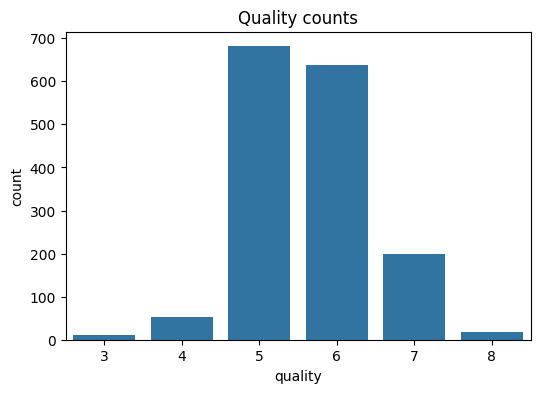

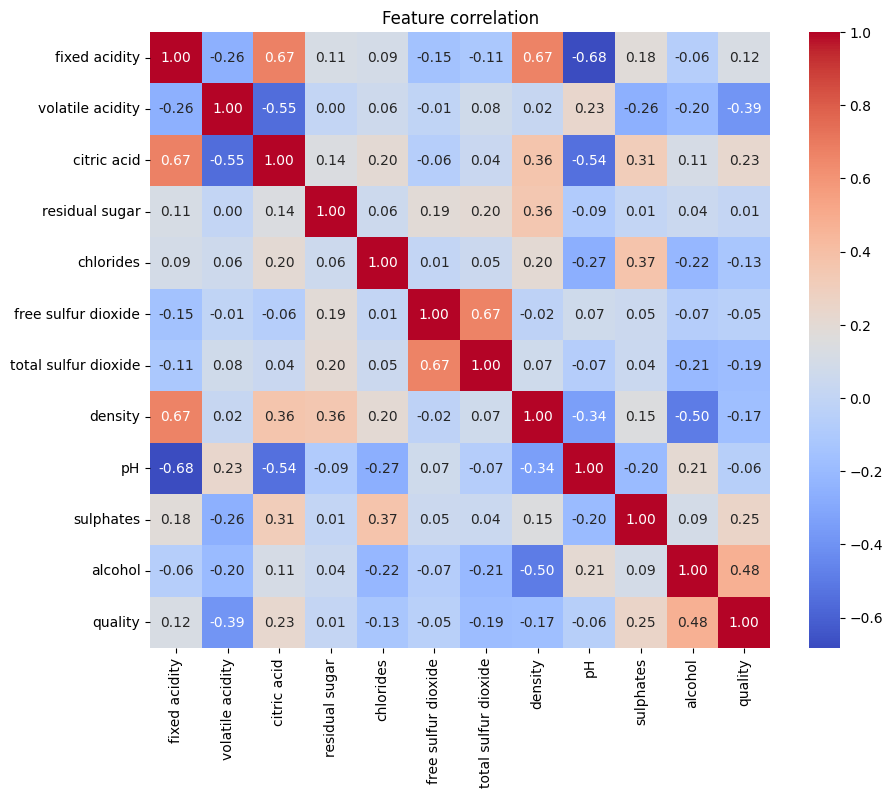

In [4]:
# Basic info
print("shape:", df.shape)
print(df.info())
print(df.describe())

# Missing values
print("missing per column:\n", df.isnull().sum())

# Distribution of target
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x='quality', data=df)
plt.title('Quality counts')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature correlation')
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# quick check
print("X_train shape:", X_train_scaled.shape, "X_test shape:", X_test_scaled.shape)


X_train shape: (1279, 11) X_test shape: (320, 11)


In [6]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Ridge': Ridge()
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {'rmse': rmse, 'mae': mae, 'r2': r2}
    print(f"{name} --> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")


RandomForest --> RMSE: 0.548, MAE: 0.422, R2: 0.540
GradientBoosting --> RMSE: 0.602, MAE: 0.485, R2: 0.446
Ridge --> RMSE: 0.625, MAE: 0.504, R2: 0.403


In [7]:
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=100, random_state=42)
scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rmse_scores = np.sqrt(-scores)
print("CV RMSE scores:", np.round(rmse_scores,3))
print("CV RMSE mean:", rmse_scores.mean().round(3))


CV RMSE scores: [0.645 0.615 0.639 0.617 0.527]
CV RMSE mean: 0.609


In [8]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rsearch = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_dist,
                             n_iter=8, cv=3, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
rsearch.fit(X_train_scaled, y_train)
print("Best params:", rsearch.best_params_)
best_model = rsearch.best_estimator_


Best params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}


Final model RMSE: 0.552, MAE: 0.427, R2: 0.534


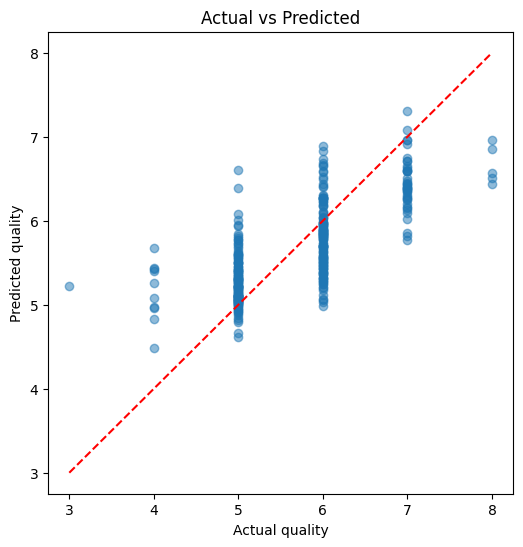

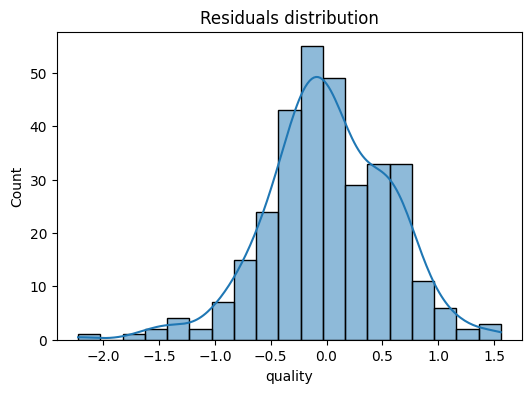

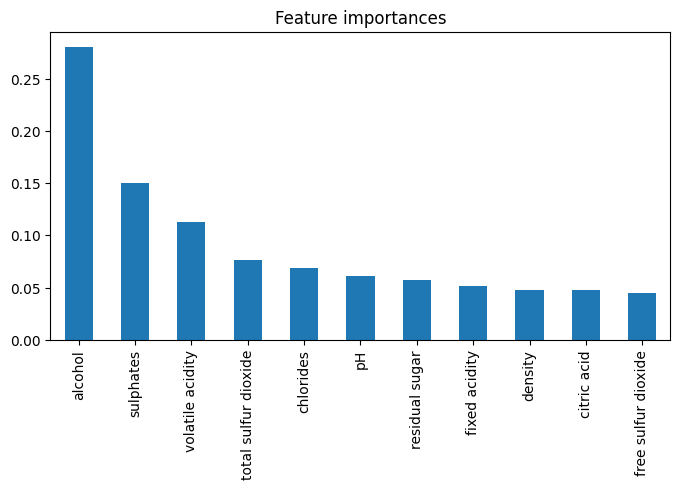

In [9]:
# predictions
preds = best_model.predict(X_test_scaled)

# metrics
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)
print(f"Final model RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

# Actual vs Predicted scatter
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual quality')
plt.ylabel('Predicted quality')
plt.title('Actual vs Predicted')
plt.show()

# Residual distribution
residuals = y_test - preds
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title('Residuals distribution')
plt.show()

# Feature importances (if tree model)
import pandas as pd
feat_imp = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
feat_imp.plot.bar()
plt.title('Feature importances')
plt.show()


In [10]:
import joblib
joblib.dump(best_model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Copy to Drive if mounted
!cp model.pkl /content/drive/MyDrive/wine_quality_artifacts/
!cp scaler.pkl /content/drive/MyDrive/wine_quality_artifacts/
print("Saved model and scaler to local and Drive (if mounted).")


cp: cannot create regular file '/content/drive/MyDrive/wine_quality_artifacts/': No such file or directory
cp: cannot create regular file '/content/drive/MyDrive/wine_quality_artifacts/': No such file or directory
Saved model and scaler to local and Drive (if mounted).


In [14]:
from google.colab import files
files.download('model.pkl')
files.download('scaler.pkl')
files.download('app.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# binary target (good if quality >=7)
y_bin = (df['quality'] >= 7).astype(int)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y_bin, test_size=0.2, random_state=42)
scaler_b = StandardScaler()
X_train_b = scaler_b.fit_transform(X_train_b)
X_test_b = scaler_b.transform(X_test_b)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_b, y_train_b)
y_pred_b = clf.predict(X_test_b)
print(classification_report(y_test_b, y_pred_b))
print("Confusion matrix:\n", confusion_matrix(y_test_b, y_pred_b))


              precision    recall  f1-score   support

           0       0.92      0.97      0.94       273
           1       0.73      0.51      0.60        47

    accuracy                           0.90       320
   macro avg       0.82      0.74      0.77       320
weighted avg       0.89      0.90      0.89       320

Confusion matrix:
 [[264   9]
 [ 23  24]]


In [13]:
app_code = """
import streamlit as st
import pandas as pd
import joblib
import numpy as np

st.title('Wine Quality Predictor (Regression)')

# load model & scaler
model = joblib.load('model.pkl')
scaler = joblib.load('scaler.pkl')

st.sidebar.header('Input features')
def user_input_features():
    fixed_acidity = st.sidebar.slider('fixed acidity', 3.0, 16.0, 7.4)
    volatile_acidity = st.sidebar.slider('volatile acidity', 0.0, 1.5, 0.7)
    citric_acid = st.sidebar.slider('citric acid', 0.0, 1.0, 0.0)
    residual_sugar = st.sidebar.slider('residual sugar', 0.6, 65.0, 1.9)
    chlorides = st.sidebar.slider('chlorides', 0.01, 0.2, 0.076)
    free_sulfur_dioxide = st.sidebar.slider('free sulfur dioxide', 1.0, 72.0, 11.0)
    total_sulfur_dioxide = st.sidebar.slider('total sulfur dioxide', 6.0, 289.0, 34.0)
    density = st.sidebar.slider('density', 0.990, 1.005, 0.9978)
    pH = st.sidebar.slider('pH', 2.7, 4.0, 3.51)
    sulphates = st.sidebar.slider('sulphates', 0.2, 2.0, 0.56)
    alcohol = st.sidebar.slider('alcohol', 8.0, 15.0, 9.4)
    data = {'fixed acidity': fixed_acidity,
            'volatile acidity': volatile_acidity,
            'citric acid': citric_acid,
            'residual sugar': residual_sugar,
            'chlorides': chlorides,
            'free sulfur dioxide': free_sulfur_dioxide,
            'total sulfur dioxide': total_sulfur_dioxide,
            'density': density,
            'pH': pH,
            'sulphates': sulphates,
            'alcohol': alcohol}
    features = pd.DataFrame(data, index=[0])
    return features

input_df = user_input_features()
st.subheader('User input features')
st.write(input_df)

# scale and predict
scaled = scaler.transform(input_df)
prediction = model.predict(scaled)
st.subheader('Predicted quality (score)')
st.write(float(prediction[0]))
"""
with open('app.py', 'w') as f:
    f.write(app_code)
print("app.py created. To run locally: streamlit run app.py")


app.py created. To run locally: streamlit run app.py
